In [32]:
import math
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T

from mmcv.cnn import ConvModule
from mmcv.cnn import build_norm_layer


from PIL import Image
from collections import OrderedDict

In [2]:
# import mmcv
# from mmcv.runner import load_checkpoint, BaseModule

## loading seaformer model

In [3]:
# weights_cls = torch.load('SeaFormer_S_cls_73.4.pth.tar', map_location=torch.device('cpu'))

In [2]:
weights_bs = torch.load('SeaFormer_S_bs32_39.5.pth', map_location=torch.device('cpu'))

In [3]:
# for key in weights_bs['state_dict'].keys():
#     print(key)

In [4]:
class Conv2d_BN(nn.Module):
    def __init__(self, a, b, ks=1, stride=1, pad=0, dilation=1,
                 groups=1, bn_weight_init=1, bias=False):
        super().__init__()
        self.inp_channel = a
        self.out_channel = b
        self.ks = ks
        self.pad = pad
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        # self.bias = bias
        self.model = nn.Sequential()
        self.model.add_module('c', nn.Conv2d(
            a, b, ks, stride, pad, dilation, groups, bias=bias))
        
        # build_norm_layer can be replaced by BatchNorm2d and then norm_cfg not required also parameters remain same.
#         bn = build_norm_layer(norm_cfg, b)[1]
        bn = nn.BatchNorm2d(b)
        nn.init.constant_(bn.weight, bn_weight_init)
        nn.init.constant_(bn.bias, 0)
        self.model.add_module('bn', bn)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.ReLU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Conv2d_BN(in_features, hidden_features)
        self.dwconv = nn.Conv2d(hidden_features, hidden_features, 3, 1, 1, bias=True, groups=hidden_features)
        self.act = act_layer()
        self.fc2 = Conv2d_BN(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [7]:
class InvertedResidual(nn.Module):
    def __init__(
            self,
            inp: int,
            oup: int,
            ks: int,
            stride: int,
            expand_ratio: int,
            activations=None,
            norm_cfg=dict(type='BN', requires_grad=True)
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.expand_ratio = expand_ratio
        assert stride in [1, 2]

        if activations is None:
            activations = nn.ReLU

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(Conv2d_BN(inp, hidden_dim, ks=1))
            layers.append(activations())
        layers.extend([
            # dw
            Conv2d_BN(hidden_dim, hidden_dim, ks=ks, stride=stride, pad=ks // 2, groups=hidden_dim),
            activations(),
            # pw-linear
            Conv2d_BN(hidden_dim, oup, ks=1)
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [8]:
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
#     print(new_v)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [9]:
class StackedMV2Block(nn.Module):
    def __init__(
            self,
            cfgs,
            stem,
            inp_channel=16,
            activation=nn.ReLU,
            norm_cfg=dict(type='BN', requires_grad=True),
            width_mult=1.):
        
        super().__init__()
        
        self.stem = stem
        if stem:
            self.stem_block = nn.Sequential(
                Conv2d_BN(3, inp_channel, 3, 2, 1),
                activation()
            )
            
        self.cfgs = cfgs

        self.layers = []
        
        for i, (k, t, c, s) in enumerate(cfgs):
            output_channel = _make_divisible(c * width_mult, 8)
            print(output_channel)
            exp_size = t * inp_channel
            exp_size = _make_divisible(exp_size * width_mult, 8)
#             print(exp_size)
            layer_name = 'layer{}'.format(i + 1)
            layer = InvertedResidual(inp_channel, output_channel, ks=k, stride=s, expand_ratio=t, activations=activation)
            self.add_module(layer_name, layer)
            inp_channel = output_channel
            self.layers.append(layer_name)

    def forward(self, x):
        if self.stem:
            x = self.stem_block(x)
        for i, layer_name in enumerate(self.layers):
            layer = getattr(self, layer_name)
            x = layer(x)
        return x

In [10]:
class SqueezeAxialPositionalEmbedding(nn.Module):
    def __init__(self, dim, shape):
        super().__init__()
        
        self.pos_embed = nn.Parameter(torch.randn([1, dim, shape]))

    def forward(self, x):
        B, C, N = x.shape
        x = x + F.interpolate(self.pos_embed, size=(N), mode='linear', align_corners=False)
        
        return x

In [11]:
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

In [12]:
class Sea_Attention(torch.nn.Module):
    def __init__(self, dim=3, key_dim=64, num_heads=8,
                 attn_ratio=2,
                 activation=None):
        
        super().__init__()
        self.num_heads = num_heads
        self.scale = key_dim ** -0.5
        self.key_dim = key_dim
        self.nh_kd = nh_kd = key_dim * num_heads  # num_head key_dim
        self.d = int(attn_ratio * key_dim)
        self.dh = int(attn_ratio * key_dim) * num_heads
        self.attn_ratio = attn_ratio

        self.to_q = Conv2d_BN(dim, nh_kd, 1)
        self.to_k = Conv2d_BN(dim, nh_kd, 1)
        self.to_v = Conv2d_BN(dim, self.dh, 1)
        
        if activation==None:
            activation = nn.ReLU
        
        self.proj = torch.nn.Sequential(activation(), Conv2d_BN(
            self.dh, dim, bn_weight_init=0))
        
        
        self.proj_encode_row = torch.nn.Sequential(activation(), Conv2d_BN(
            self.dh, self.dh, bn_weight_init=0))
        self.pos_emb_rowq = SqueezeAxialPositionalEmbedding(nh_kd, 16)
        self.pos_emb_rowk = SqueezeAxialPositionalEmbedding(nh_kd, 16)

        
        self.proj_encode_column = torch.nn.Sequential(activation(), Conv2d_BN(
            self.dh, self.dh, bn_weight_init=0))
        self.pos_emb_columnq = SqueezeAxialPositionalEmbedding(nh_kd, 16)
        self.pos_emb_columnk = SqueezeAxialPositionalEmbedding(nh_kd, 16)
        
        
        self.dwconv = Conv2d_BN(self.dh + 2 * self.nh_kd, 2 * self.nh_kd + self.dh, ks=3, stride=1, pad=1, dilation=1,
                                groups=2 * self.nh_kd + self.dh)
        self.act = activation()
        self.pwconv = Conv2d_BN(2 * self.nh_kd + self.dh, dim, ks=1)
        self.sigmoid = h_sigmoid()

        
    def forward(self, x):  
        B, C, H, W = x.shape

        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)
        
        # detail enhance
        qkv = torch.cat([q, k, v], dim=1)
        qkv = self.act(self.dwconv(qkv))
        qkv = self.pwconv(qkv)

        # squeeze axial attention
        ## squeeze row
        qrow = self.pos_emb_rowq(q.mean(-1)).reshape(B, self.num_heads, -1, H).permute(0, 1, 3, 2)
        krow = self.pos_emb_rowk(k.mean(-1)).reshape(B, self.num_heads, -1, H)
        vrow = v.mean(-1).reshape(B, self.num_heads, -1, H).permute(0, 1, 3, 2)
        attn_row = torch.matmul(qrow, krow) * self.scale
        attn_row = attn_row.softmax(dim=-1)
        xx_row = torch.matmul(attn_row, vrow)  # B nH H C
        xx_row = self.proj_encode_row(xx_row.permute(0, 1, 3, 2).reshape(B, self.dh, H, 1))

        ## squeeze column
        qcolumn = self.pos_emb_columnq(q.mean(-2)).reshape(B, self.num_heads, -1, W).permute(0, 1, 3, 2)
        kcolumn = self.pos_emb_columnk(k.mean(-2)).reshape(B, self.num_heads, -1, W)
        vcolumn = v.mean(-2).reshape(B, self.num_heads, -1, W).permute(0, 1, 3, 2)
        attn_column = torch.matmul(qcolumn, kcolumn) * self.scale
        attn_column = attn_column.softmax(dim=-1)
        xx_column = torch.matmul(attn_column, vcolumn)  # B nH W C
        xx_column = self.proj_encode_column(xx_column.permute(0, 1, 3, 2).reshape(B, self.dh, 1, W))

        xx = xx_row.add(xx_column)
        xx = v.add(xx)
        xx = self.proj(xx)
        
        xx = self.sigmoid(xx) * qkv
        return xx

In [13]:
class Block(nn.Module):

    def __init__(self, dim=3, key_dim=64, num_heads=8, mlp_ratio=4., attn_ratio=2., drop=0.,
                 drop_path=0., act_layer=nn.ReLU, norm_cfg=dict(type='BN2d', requires_grad=True)):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
       
        self.attn = Sea_Attention(dim, key_dim=key_dim, num_heads=num_heads, attn_ratio=attn_ratio,
                                      activation=act_layer)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x1):
        x1 = x1 + self.drop_path(self.attn(x1))
        x1 = x1 + self.drop_path(self.mlp(x1))
        return x1

In [14]:
class BasicLayer(nn.Module):
    def __init__(self, block_num=4, embedding_dim=3, key_dim=64, num_heads=8,
                 mlp_ratio=4., attn_ratio=2., drop=0., attn_drop=0., drop_path=0.,
                 norm_cfg=dict(type='BN2d', requires_grad=True),
                 act_layer=nn.ReLU):
        super().__init__()
        self.block_num = block_num

        self.transformer_blocks = nn.ModuleList()
        for i in range(self.block_num):
            self.transformer_blocks.append(Block(
                embedding_dim, key_dim=key_dim, num_heads=num_heads,
                mlp_ratio=mlp_ratio, attn_ratio=attn_ratio,
                drop=drop, drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_cfg=norm_cfg,
                act_layer=act_layer))

    def forward(self, x):
        # token * N
        for i in range(self.block_num):
            x = self.transformer_blocks[i](x)
        return x

In [15]:
class Fusion_block(nn.Module):
    def __init__(
            self,
            inp: int,
            oup: int,
            embed_dim: int,
            norm_cfg=dict(type='BN', requires_grad=True),
            activations=None,
    ) -> None:
        super(Fusion_block, self).__init__()
        self.norm_cfg = norm_cfg
        self.local_embedding = ConvModule(inp, embed_dim, kernel_size=1, norm_cfg=self.norm_cfg, act_cfg=None)
        self.global_act = ConvModule(oup, embed_dim, kernel_size=1, norm_cfg=self.norm_cfg, act_cfg=None)
        self.act = h_sigmoid()

    def forward(self, x_l, x_g):
        '''
        x_g: global features
        x_l: local features
        '''
        B, C, H, W = x_l.shape
        B, C_c, H_c, W_c = x_g.shape

        local_feat = self.local_embedding(x_l)
        global_act = self.global_act(x_g)
        sig_act = F.interpolate(self.act(global_act), size=(H, W), mode='bilinear', align_corners=False)
        out = local_feat * sig_act
        return out

In [17]:
class StackedMV2Block(nn.Module):
    def __init__(
            self,
            cfgs,
            stem,
            inp_channel=16,
            activation=nn.ReLU,
            norm_cfg=dict(type='BN', requires_grad=True),
            width_mult=1.):
        
        super().__init__()
        
        self.stem = stem
        if stem:
            self.stem_block = nn.Sequential(
                Conv2d_BN(3, inp_channel, 3, 2, 1),
                activation()
            )
            
        self.cfgs = cfgs

        self.layers = []
        
        for i, (k, t, c, s) in enumerate(cfgs):
            output_channel = _make_divisible(c * width_mult, 8)
#             print(output_channel)
            exp_size = t * inp_channel
            exp_size = _make_divisible(exp_size * width_mult, 8)
#             print(exp_size)
            layer_name = 'layer{}'.format(i + 1)
            layer = InvertedResidual(inp_channel, output_channel, ks=k, stride=s, expand_ratio=t, activations=activation)
            self.add_module(layer_name, layer)
            inp_channel = output_channel
            self.layers.append(layer_name)

    def forward(self, x):
        if self.stem:
            x = self.stem_block(x)
        for i, layer_name in enumerate(self.layers):
            layer = getattr(self, layer_name)
            x = layer(x)
        return x

stacked_mv2 = StackedMV2Block([(3,2,3,1), (3,2,5,1), (3,2,3,1)] ,True)

In [18]:
class SeaFormer(nn.Module):
    def __init__(self,
                 cfgs,
                 channels,
                 emb_dims,
                 key_dims,
                 depths=[2, 2],
                 num_heads=8,
                 attn_ratios=2,
                 mlp_ratios=[2, 4],
                 drop_path_rate=0.,
                 norm_cfg=dict(type='BN', requires_grad=True),
                 act_layer=nn.ReLU6,
                 num_classes=125,
                 init_cfg=None,
                 **args):
        super().__init__()
        self.num_classes = num_classes
        self.channels = channels
        self.depths = depths
        self.cfgs = cfgs
        self.norm_cfg = norm_cfg
        self.init_cfg = init_cfg
        if self.init_cfg is not None:
            self.pretrained = self.init_cfg['checkpoint']

        for i in range(len(cfgs)):
            smb = StackedMV2Block(cfgs=cfgs[i], stem=True if i == 0 else False, inp_channel=channels[i],
                                  norm_cfg=norm_cfg)
            setattr(self, f"smb{i + 1}", smb)

        for i in range(len(depths)):
            dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depths[i])]  # stochastic depth decay rule
            trans = BasicLayer(
                block_num=depths[i],
                embedding_dim=emb_dims[i],
                key_dim=key_dims[i],
                num_heads=num_heads,
                mlp_ratio=mlp_ratios[i],
                attn_ratio=attn_ratios,
                drop=0, attn_drop=0,
                drop_path=dpr,
                norm_cfg=norm_cfg,
                act_layer=act_layer)
            setattr(self, f"trans{i + 1}", trans)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                n //= m.groups
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

        if isinstance(self.pretrained, str):
            logger = get_root_logger()
            checkpoint = _load_checkpoint(self.pretrained, logger=logger, map_location='cpu')
            if 'state_dict_ema' in checkpoint:
                state_dict = checkpoint['state_dict_ema']
            elif 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            elif 'model' in checkpoint:
                state_dict = checkpoint['model']
            else:
                state_dict = checkpoint
            self.load_state_dict(state_dict, False)

    def forward(self, x):
        outputs = []
        num_smb_stage = len(self.cfgs)
        num_trans_stage = len(self.depths)
        for i in range(num_smb_stage):
            smb = getattr(self, f"smb{i + 1}")
            x = smb(x)
            # 1/8 shared feat
            if i == 1:
                outputs.append(x)
            if num_trans_stage + i >= num_smb_stage:
                trans = getattr(self, f"trans{i + num_trans_stage - num_smb_stage + 1}")
                x = trans(x)
                outputs.append(x)

        return outputs

In [20]:
model_cfgs = dict(
        cfgs  = [
            # k,  t,  c, s
            [[3, 1, 16, 1],  
             [3, 4, 24, 2], 
             [3, 3, 24, 1]],
  
            [[5, 3, 48, 2],  
             [5, 3, 48, 1]],
              
            [[3, 3, 96, 2],  
             [3, 3, 96, 1]],
            
            [[5, 4, 160, 2]],
              
            [[3, 6, 192, 2]]
            
        ],  
        channels=[16, 24, 48, 96, 160, 192],
        depths=[3, 3],
        key_dims=[16, 24],
        emb_dims=[160, 192],
        num_heads=6,
        drop_path_rate=0,
)

In [21]:
base = SeaFormer(**model_cfgs)

In [19]:
# class LightHead(BaseModule):
class LightHead(nn.Module):
    """
    SEA-Former: Squeeze-enhanced Axial Transformer for Mobile Semantic Segmentation
    """

    def __init__(self, embed_dims, channels, in_index, in_channels, num_classes, norm_cfg=None, act_cfg=dict(type='ReLU'), is_dw=False, **kwargs):
        super(LightHead, self).__init__()

        head_channels = channels
        in_channels = in_channels
        self.in_index = in_index
        self.linear_fuse = ConvModule(
            in_channels=head_channels,
            out_channels=head_channels,
            kernel_size=1,
            stride=1,
            groups=head_channels if is_dw else 1,
            norm_cfg=norm_cfg,
            act_cfg=act_cfg
        )
        for i in range(len(embed_dims)):
            fuse = Fusion_block(in_channels[0] if i == 0 else embed_dims[i - 1], in_channels[i + 1],
                                embed_dim=embed_dims[i], norm_cfg=norm_cfg)
            setattr(self, f"fuse{i + 1}", fuse)
        self.embed_dims = embed_dims
        self.conv_seg = nn.Conv2d(head_channels, num_classes, kernel_size=1)

    def forward(self, inputs):
        xx = [inputs[i] for i in self.in_index]
        x_detail = xx[0]
        for i in range(len(self.embed_dims)):
            fuse = getattr(self, f"fuse{i + 1}")
            x_detail = fuse(x_detail, xx[i + 1])
        _c = self.linear_fuse(x_detail)
        x = self.conv_seg(_c)
        return x

In [22]:
norm_cfg = dict(type='BN', requires_grad=True)

head_cfg = {'in_channels':[48, 160, 192],
            'in_index':[0, 1, 2],
            'channels':128,
            'dropout_ratio':0,
            'embed_dims':[96, 128],
            'num_classes':150,
            'is_dw':True,
            'norm_cfg':norm_cfg,
            'align_corners':False}

In [23]:
head = LightHead(**head_cfg)

In [24]:
class Segmentor(nn.Module):
    def __init__(self,
                 backbone,
                 decode_head):
        super(Segmentor, self).__init__()
        self.backbone = backbone
        self.decode_head = decode_head

    def forward(self, img):
        x = self.backbone(img)
        out = self.decode_head(x)
        return out

In [25]:
model = Segmentor(base, head)

In [26]:
model

Segmentor(
  (backbone): SeaFormer(
    (smb1): StackedMV2Block(
      (stem_block): Sequential(
        (0): Conv2d_BN(
          (model): Sequential(
            (c): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ReLU()
      )
      (layer1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d_BN(
            (model): Sequential(
              (c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (1): ReLU()
          (2): Conv2d_BN(
            (model): Sequential(
              (c): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [28]:
state_dict = OrderedDict()

In [29]:
# because of changes in Conv2dBN state_dict of this model has 'model' term
# below we are removing it before finding original weight
i = 0
for key in model.state_dict().keys():
    state_dict[key] = weights_bs['state_dict'][('.').join([i for i in key.split('.') if i!='model'])]
    i+=1

In [30]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [58]:
print(i)

590


In [59]:
len(weights_bs['state_dict'])

590

In [60]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f'Total number of parameters are {round(pytorch_total_params/10_00_000)}M'

'Total number of parameters are 4M'

## Inference

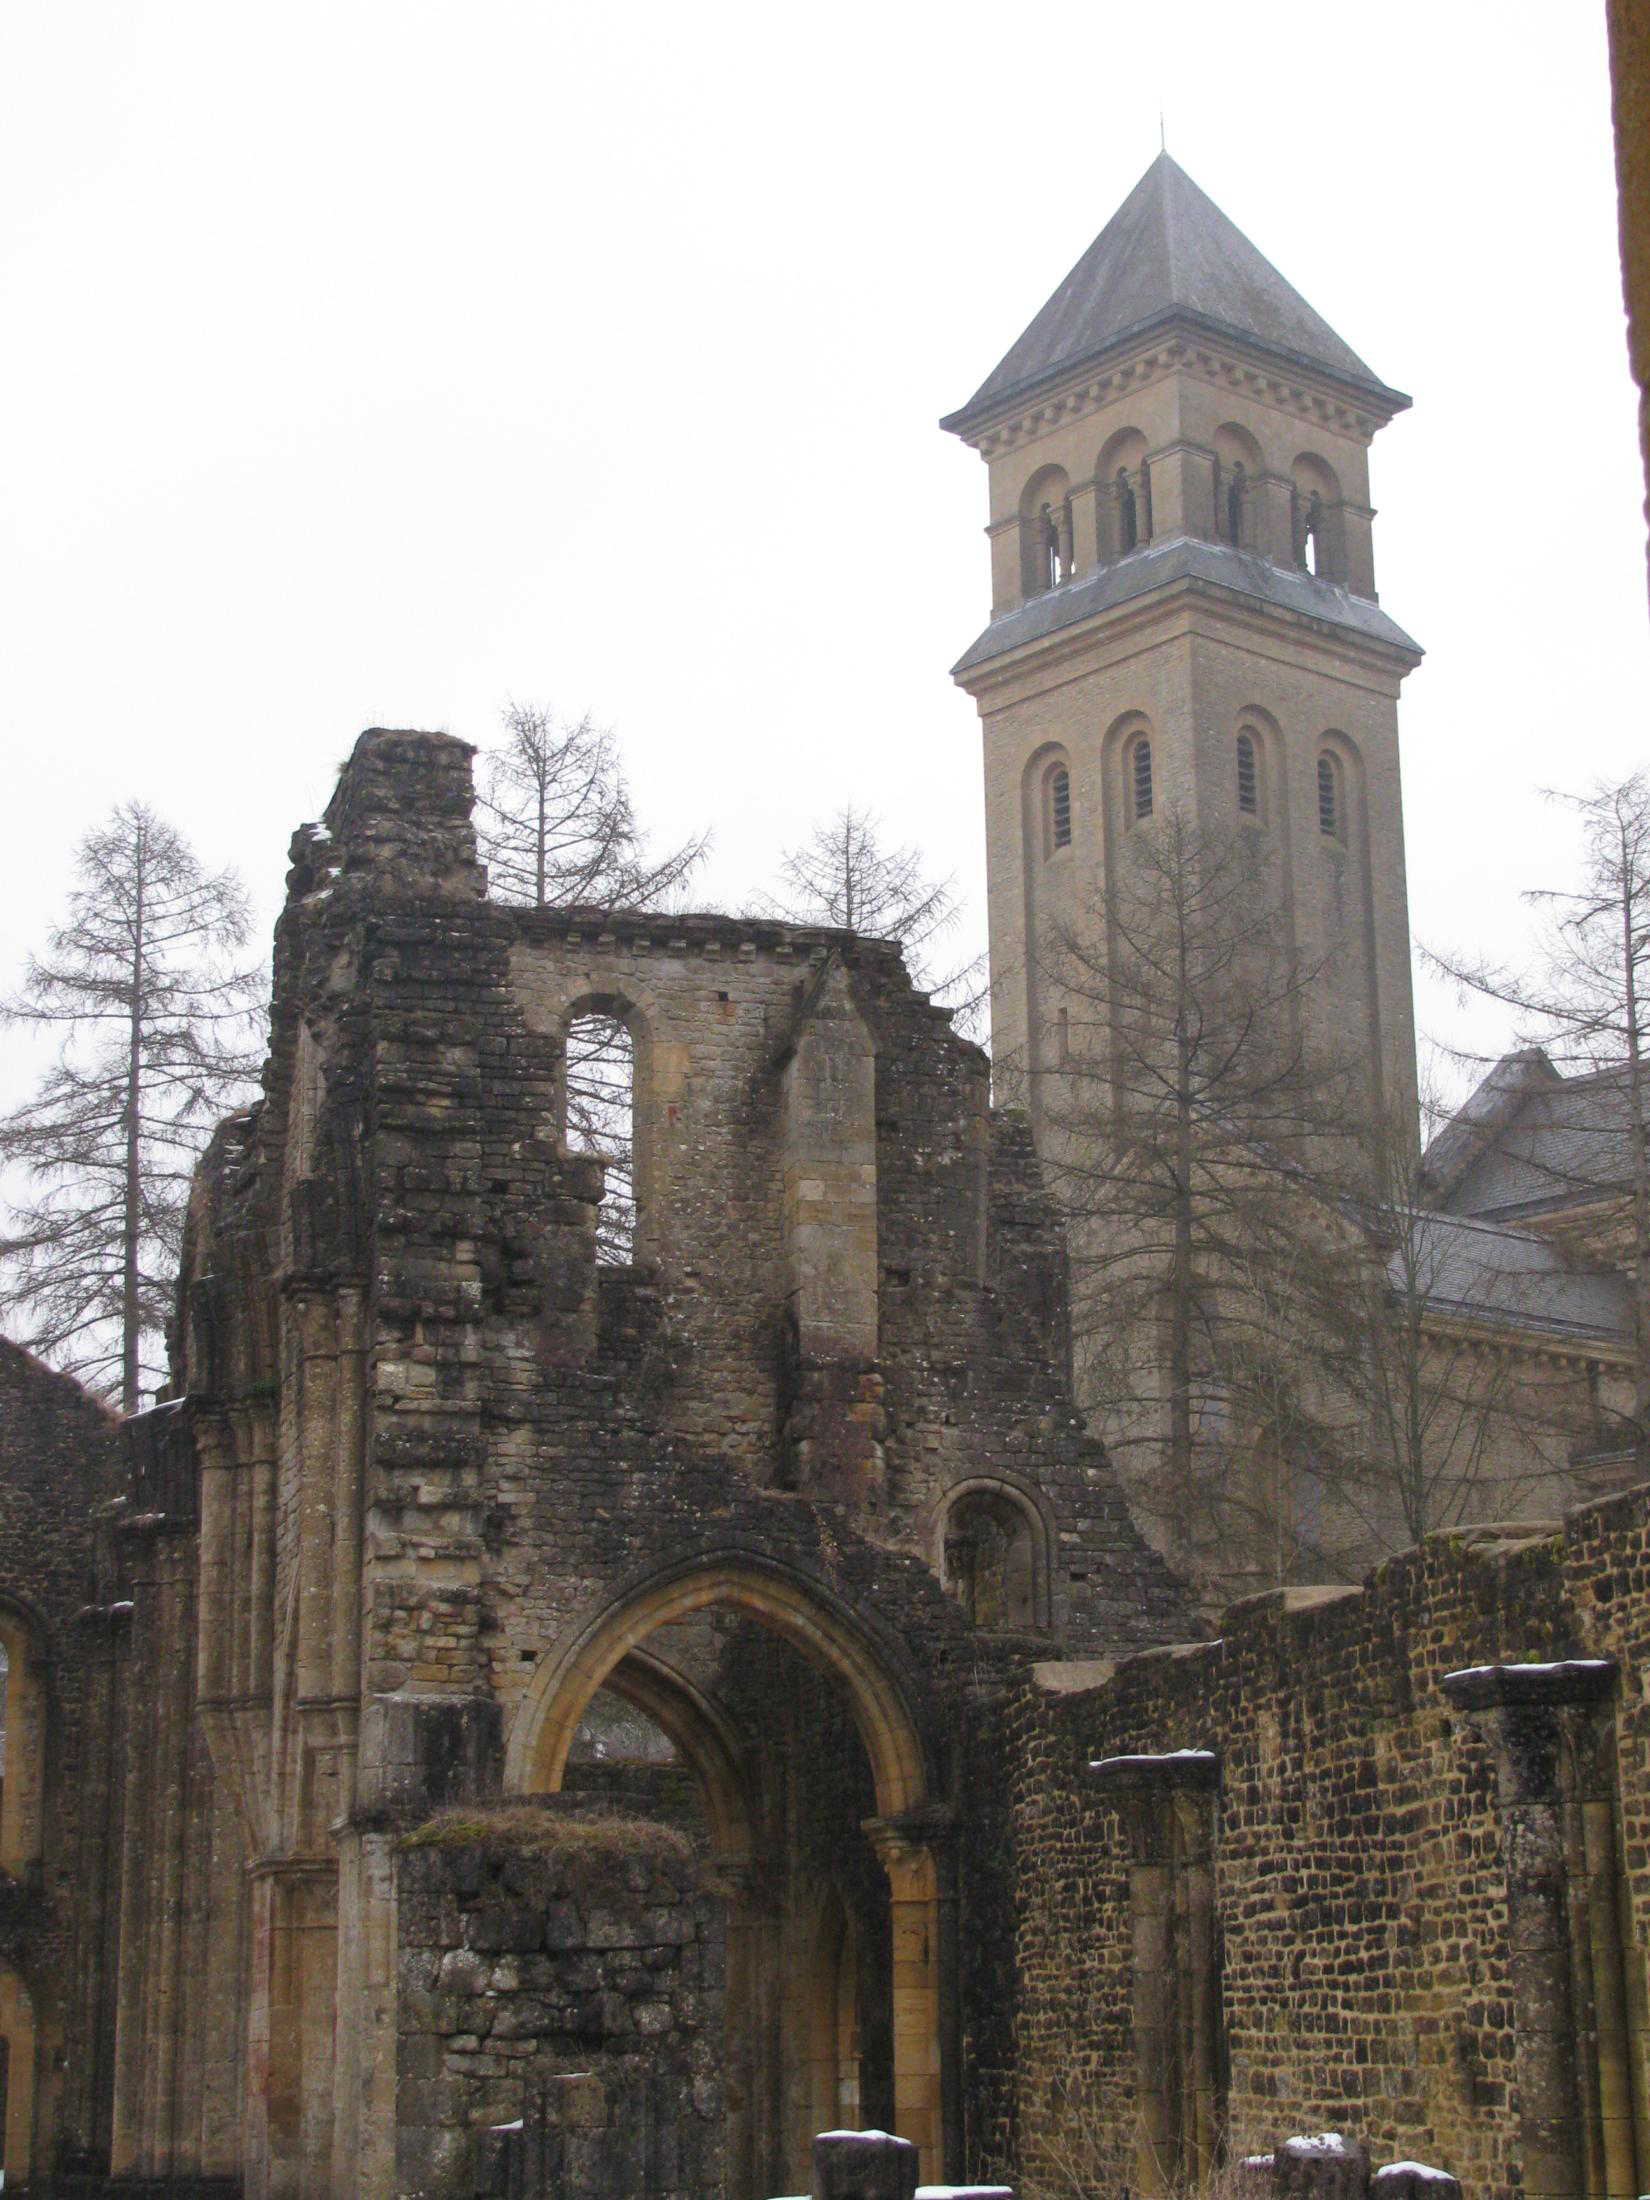

In [33]:
im = Image.open("ADE_val_00001001.jpg")  
im

In [39]:
transform = T.Compose([T.Resize([512, 512]), T.ToTensor(), T.Lambda(lambda x:x.unsqueeze(0))])
inp_img = transform(im)
inp_img.shape

torch.Size([1, 3, 512, 512])

In [41]:
logits = model(inp_img)
logits.shape

torch.Size([1, 150, 64, 64])

In [49]:
final_out = logits.argmax(1)
final_out = final_out.to(torch.float)
final_out.shape

torch.Size([1, 64, 64])

In [50]:
final_out_scaled = torch.nn.functional.interpolate(final_out.unsqueeze(dim=0), size=512, mode="bilinear", align_corners=False)
final_out_scaled.shape

torch.Size([1, 1, 512, 512])

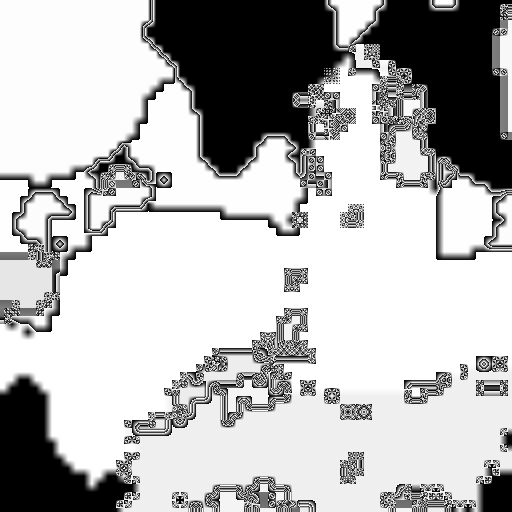

In [51]:
transform = T.ToPILImage()
img = transform(final_out_scaled.squeeze(0))
img

In [52]:
# generating 125 (r,g,b) colors using values present in color_levels array 
color_levels = np.array([0, 64, 128, 192, 255])

def all_comb(levels=color_levels, n=3):
    if n==1:
        return levels.reshape(-1, 1)
    
    combs = []
    
    for i, lvl in enumerate(levels):
        combs_lvl = all_comb(levels, n-1)
        combs_local = [np.append(lvl, comb) for comb in combs_lvl]
        combs.extend(combs_local)
                
    return combs

label_colors  = all_comb(color_levels, n=3)

In [53]:
# Define the helper function
def decode_segmap(image, nc=125):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l][0]
        g[idx] = label_colors[l][1]
        b[idx] = label_colors[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [54]:
rgb_image = decode_segmap(final_out_scaled.squeeze(0).squeeze(0).numpy())

In [55]:
rgb_image = rgb_image.reshape(3, 512, 512)

In [56]:
rgb_img_tensor = torch.from_numpy(rgb_image)

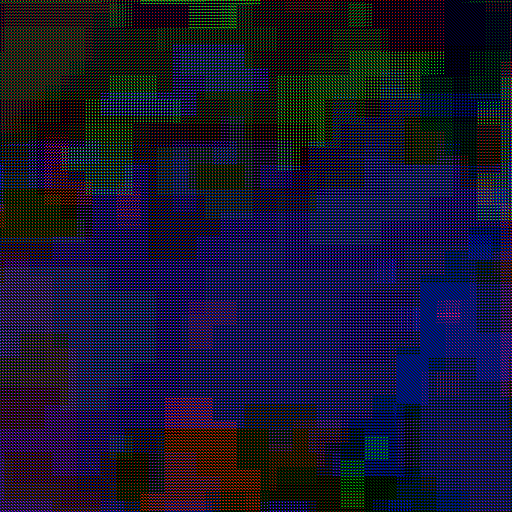

In [57]:
transform(rgb_img_tensor)